# 基于Transformer模型的情感分析与情感识别研究
## 项目简介
本项目通过基于Transformer模型的情感分析和情感识别研究，为社会提供了更准确、高效的情感分析技术。这将在市场调研、社交媒体分析、舆情监测等领域发挥重要作用，帮助企业了解用户情感倾向、产品满意度以及品牌声誉等关键信息，从而支持决策制定和运营优化。

同时，对于刚接触神经网络的我来说，这个项目提供了宝贵的机会，能够通过深入研究和实践Transformer模型，提升自然语言处理和深度学习的技能，展示出扎实的研究能力和解决实际问题的能力，并为学术和职业发展奠定坚实基础。

## 导入库

In [1]:
import torch
import copy
import collections
import os
import random
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchtext.vocab import vocab
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

## 参数设置

In [2]:
class Config(object):
    def __init__(self):
        self.model_name = 'Transformer'
        # 预训练词向量，此处为None
        self.embedding_pretrained = None  
        # 测试设备种类，本次实验使用的显卡是RTX1660Ti
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        # 随机失活，防止过拟合
        self.dropout = 0.5 
        # 类别数，此处为2分类
        self.num_classes = 2  
        # epoch数，可以根据需要调整
        self.num_epochs = 200
        # mini-batch大小  
        self.batch_size = 20  
        # 每句话处理成的长度，短填长切，后面会统一长度
        self.pad_size = 500 
        # 对读取数据的部分进行赋值，后面会赋值  
        self.n_vocab = None
        # 学习率
        self.learning_rate = 5e-4
        # 词向量维度  
        self.embed = 300
        # 模型的维度，与词向量维度相同
        self.dim_model = 300
        # 隐藏层大小
        self.hidden = 1024
        # 最后一个隐藏层大小
        self.last_hidden = 512
        # 头的数量，这里是5个头，后面可以调整
        self.num_head = 5
        # 编码器的数量
        self.num_encoder = 2
        # 保存模型的路径
        self.checkpoint_path = './model.ckpt'

## 数据预处理

In [3]:
class ImdbDataset(Dataset):
    # 初始化函数，得到数据并保存到data和labels中
    def __init__(
        self, folder_path="./aclImdb", is_train=True
    ) -> None:
        super().__init__()
        self.data, self.labels = self.read_dataset(folder_path, is_train)

    # 读取数据，返回数据和标签
    def read_dataset(self, folder_path, is_train):
        data, labels = [], []
        for label in ("pos", "neg"):
            folder_name = os.path.join(
                folder_path, "train" if is_train else "test", label
            )
            for file in tqdm(os.listdir(folder_name)):
                with open(os.path.join(folder_name, file), "rb") as f:
                    text = f.read().decode("utf-8").replace("\n", "").lower()
                    data.append(text)
                    labels.append(1 if label == "pos" else 0)
        # 打乱数据
        random.shuffle(data)
        random.shuffle(labels)
        return data, labels
    
    # 返回评论的数量
    def __len__(self):
        return len(self.data)

    # 返回第index条评论和标签
    def __getitem__(self, index):
        return self.data[index], int(self.labels[index])

    # 返回所有评论
    def get_data(self):
        return self.data

    # 返回所有标签
    def get_labels(self):
        return self.labels
    

# 获取数据集的词元列表，将每条评论转换成词元列表
def get_tokenized(data):
    def tokenizer(text):
        return [tok.lower() for tok in text.split(" ")]
    return [tokenizer(review) for review in data]


# 获取数据集的词汇表，将词频低于min_freq的词过滤掉
def get_vocab(data):
    # 设置词频阈值，低于该阈值的词将被过滤掉
    min_freq = 5
    # 获取词元列表
    tokenized_data = get_tokenized(data)
    # 使用Counter统计词频
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    # UNK表示未知词元，PAD表示填充词元
    vocab_freq = {"<UNK>": 0, "<PAD>": 1}
    # 添加满足词频条件的单词到词汇表，并分配索引
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab_freq[word] = len(vocab_freq)
    # 构建词汇表对象并返回
    return vocab(vocab_freq)


# 数据预处理，将数据转换成神经网络可以接受的输入形式
def preprocess_imdb(train_data, vocab, config):
    # 将每条评论通过截断或者补0，使得长度变成500
    max_l = config.pad_size
    # 截短补长
    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [1] * (max_l - len(x))
    labels = train_data.get_labels()
    tokenized_data = get_tokenized(train_data.get_data())
    vocab_dict = vocab.get_stoi()
    # 将每条评论转换成词索引
    features = torch.tensor(
        [pad([vocab_dict.get(word, 0) for word in words]) for words in tokenized_data]
    )
    labels = torch.tensor([label for label in labels])
    # 返回特征和标签
    return features, labels


# 加载数据集，返回训练集、测试集和词汇表
def load_data(config):
    train_data = ImdbDataset(folder_path="./aclImdb", is_train=True)
    test_data = ImdbDataset(folder_path="./aclImdb", is_train=False)
    vocab = get_vocab(train_data.get_data())
    train_set = TensorDataset(*preprocess_imdb(train_data, vocab,config))
    test_set = TensorDataset(*preprocess_imdb(test_data, vocab,config))
    print(f"训练集大小{train_set.__len__()}")
    print(f"测试集大小{test_set.__len__()}")
    print(f"词表中单词个数:{len(vocab)}")
    # 使用DataLoader来创建数据迭代器，在训练中使用迭代器每次产生一个批次的数据
    train_iter = DataLoader(
        train_set, batch_size=config.batch_size, shuffle=True, num_workers=0
    )
    test_iter = DataLoader(test_set, config.batch_size)
    return train_iter, test_iter, vocab


# 预先定义配置
config = Config()
#加载数据
train_data,test_data,vocabs_size = load_data(config)
#词表大小额外加上一个PAD，所以加1
config.n_vocab = len(vocabs_size) + 1

100%|██████████| 12500/12500 [00:01<00:00, 8529.85it/s]


训练集大小25000
测试集大小25000
词表中单词个数:46151


## 模型训练

In [4]:
# 实现Transformer
class Model(nn.Module):
    def __init__(self, config):
        super(Model, self).__init__()
        # 定义词嵌入层，可以将词嵌入层替换成预训练的词向量
        if config.embedding_pretrained is not None:
            self.embedding = nn.Embedding.from_pretrained(config.embedding_pretrained, freeze=False)
        else:
            self.embedding = nn.Embedding(config.n_vocab, config.embed, padding_idx=config.n_vocab - 1)
        # 定义位置编码层
        self.postion_embedding = Positional_Encoding(config.embed, config.pad_size, config.dropout, config.device)
        # 定义编码器，每个编码器都包含一个多头注意力层和一个前馈神经网络层
        self.encoder = Encoder(config.dim_model, config.num_head, config.hidden, config.dropout)
        self.encoders = nn.ModuleList([
            # 共享参数，复制num_encoder份
            copy.deepcopy(self.encoder)
            for _ in range(config.num_encoder)])
        # 定义全连接层
        self.fc1 = nn.Linear(config.pad_size * config.dim_model, config.num_classes)

    # 前向传播
    def forward(self, x):
        out = self.embedding(x)
        out = self.postion_embedding(out)
        for encoder in self.encoders:
            out = encoder(out)
        # 展开后输入全连接层
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out


# 定义编码器
class Encoder(nn.Module):
    def __init__(self, dim_model, num_head, hidden, dropout):
        super(Encoder, self).__init__()
        self.attention = Multi_Head_Attention(dim_model, num_head, dropout)
        self.feed_forward = Position_wise_Feed_Forward(dim_model, hidden, dropout)

    def forward(self, x):
        out = self.attention(x)
        out = self.feed_forward(out)
        return out


# 定义位置编码层
class Positional_Encoding(nn.Module):
    def __init__(self, embed, pad_size, dropout, device):
        super(Positional_Encoding, self).__init__()
        self.device = device
        self.pe = torch.tensor([[pos / (10000.0 ** (i // 2 * 2.0 / embed)) for i in range(embed)] for pos in range(pad_size)])
        self.pe[:, 0::2] = np.sin(self.pe[:, 0::2])
        self.pe[:, 1::2] = np.cos(self.pe[:, 1::2])
        # 随机失活，防止过拟合
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = x + nn.Parameter(self.pe, requires_grad=False).to(self.device)
        out = self.dropout(out)
        return out


# 定义缩放点积注意力层
class Scaled_Dot_Product_Attention(nn.Module):
    def __init__(self):
        super(Scaled_Dot_Product_Attention, self).__init__()

    def forward(self, Q, K, V, scale=None):
        attention = torch.matmul(Q, K.permute(0, 2, 1))
        if scale:
            attention = attention * scale
        # 通过softmax函数获取每个词的权重
        attention = F.softmax(attention, dim=-1)
        context = torch.matmul(attention, V)
        return context


# 定义多头注意力层
class Multi_Head_Attention(nn.Module):
    def __init__(self, dim_model, num_head, dropout=0.0):
        super(Multi_Head_Attention, self).__init__()
        self.num_head = num_head
        assert dim_model % num_head == 0
        self.dim_head = dim_model // self.num_head
        self.fc_Q = nn.Linear(dim_model, num_head * self.dim_head)
        self.fc_K = nn.Linear(dim_model, num_head * self.dim_head)
        self.fc_V = nn.Linear(dim_model, num_head * self.dim_head)
        self.attention = Scaled_Dot_Product_Attention()
        self.fc = nn.Linear(num_head * self.dim_head, dim_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(dim_model)

    def forward(self, x):
        batch_size = x.size(0)
        Q = self.fc_Q(x)
        K = self.fc_K(x)
        V = self.fc_V(x)
        Q = Q.view(batch_size * self.num_head, -1, self.dim_head)
        K = K.view(batch_size * self.num_head, -1, self.dim_head)
        V = V.view(batch_size * self.num_head, -1, self.dim_head)

        # 缩放因子，论文中的dk，目的是为了使得点积不会太大
        scale = K.size(-1) ** -0.5  
        context = self.attention(Q, K, V, scale)

        context = context.view(batch_size, -1, self.dim_head * self.num_head)
        out = self.fc(context)
        out = self.dropout(out)

        # 残差连接
        out = out + x  
        out = self.layer_norm(out)
        return out


# 定义前馈神经网络层
class Position_wise_Feed_Forward(nn.Module):
    def __init__(self, dim_model, hidden, dropout=0.0):
        super(Position_wise_Feed_Forward, self).__init__()
        self.fc1 = nn.Linear(dim_model, hidden)
        self.fc2 = nn.Linear(hidden, dim_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(dim_model)

    def forward(self, x):
        out = self.fc1(x)
        # 使用ReLU激活函数
        out = F.relu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = out + x
        out = self.layer_norm(out)
        return out


# 定义训练函数
model = Model(config)
# 将模型放到GPU上
model.cuda()
# 定义优化器为Adam
optimizer = torch.optim.Adam(model.parameters(),lr=config.learning_rate)
# 多分类的任务
criterion = nn.CrossEntropyLoss()
# 训练模型
batch_size=config.batch_size

## 模型评估

100%|██████████| 1250/1250 [00:35<00:00, 35.47it/s]


Model Status: [001/003] | Train Acc: 0.49812 | Loss: 2.87139 | Train Precision: 0.49812 | Train Recall: 0.49812 | Train F1 Score: 0.49812 | Val Acc: 0.50000 | Loss: 1.27196 | Val Precision: 0.25000 | Val Recall: 0.50000 | Val F1 Score: 0.33333
saving model with acc 0.50000


100%|██████████| 1250/1250 [00:34<00:00, 35.83it/s]


Model Status: [002/003] | Train Acc: 0.50328 | Loss: 1.47646 | Train Precision: 0.50328 | Train Recall: 0.50328 | Train F1 Score: 0.50328 | Val Acc: 0.50000 | Loss: 0.81447 | Val Precision: 0.25000 | Val Recall: 0.50000 | Val F1 Score: 0.33333


100%|██████████| 1250/1250 [00:35<00:00, 35.59it/s]


Model Status: [003/003] | Train Acc: 0.50556 | Loss: 0.88600 | Train Precision: 0.50556 | Train Recall: 0.50556 | Train F1 Score: 0.50556 | Val Acc: 0.50000 | Loss: 0.85787 | Val Precision: 0.25000 | Val Recall: 0.50000 | Val F1 Score: 0.33333


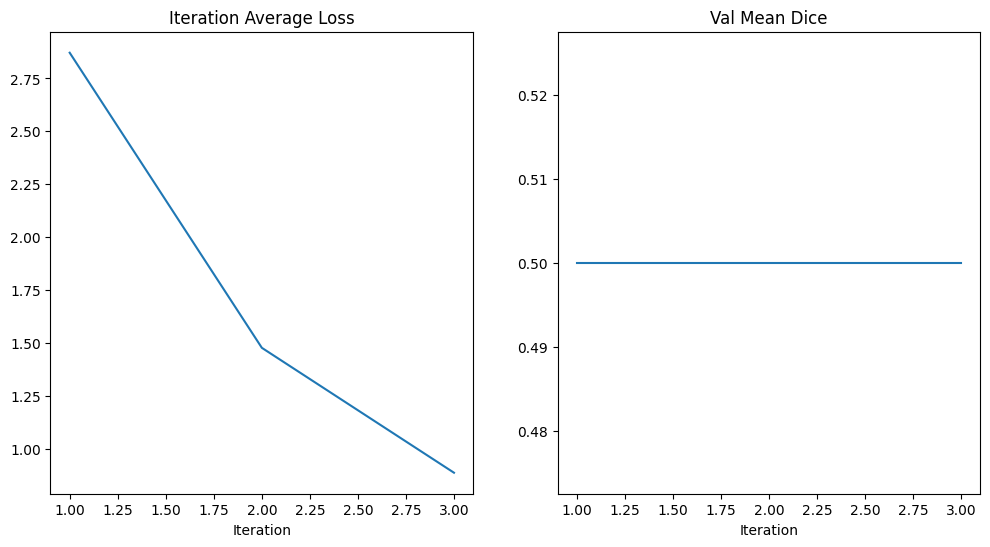

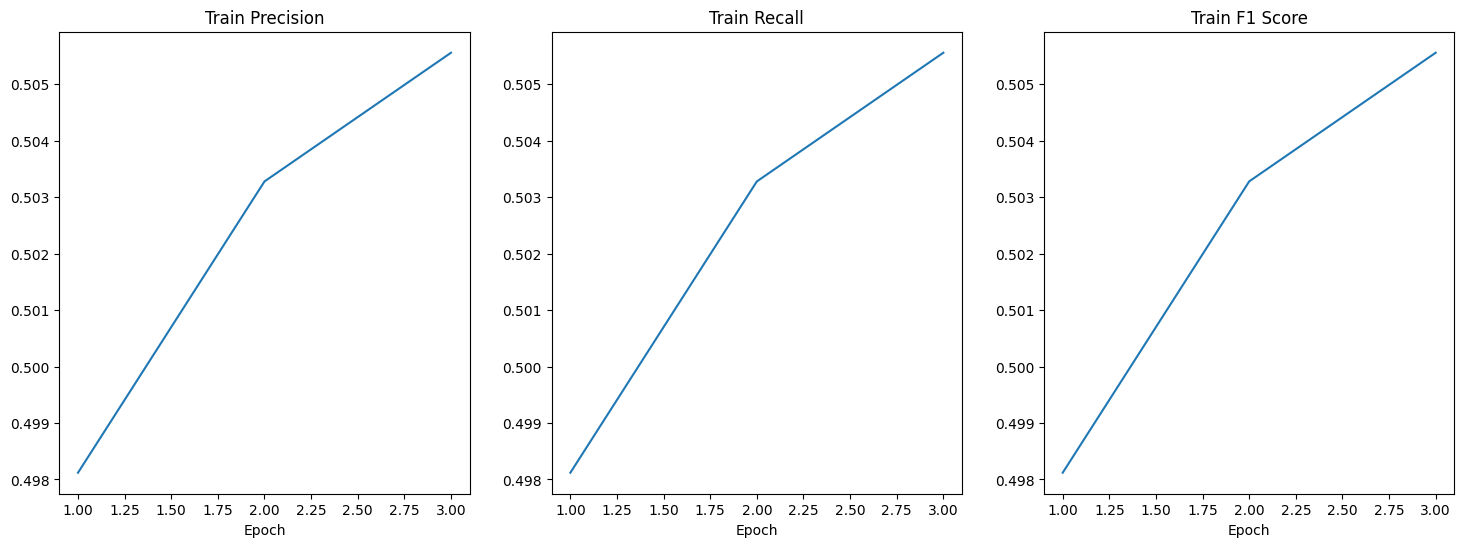

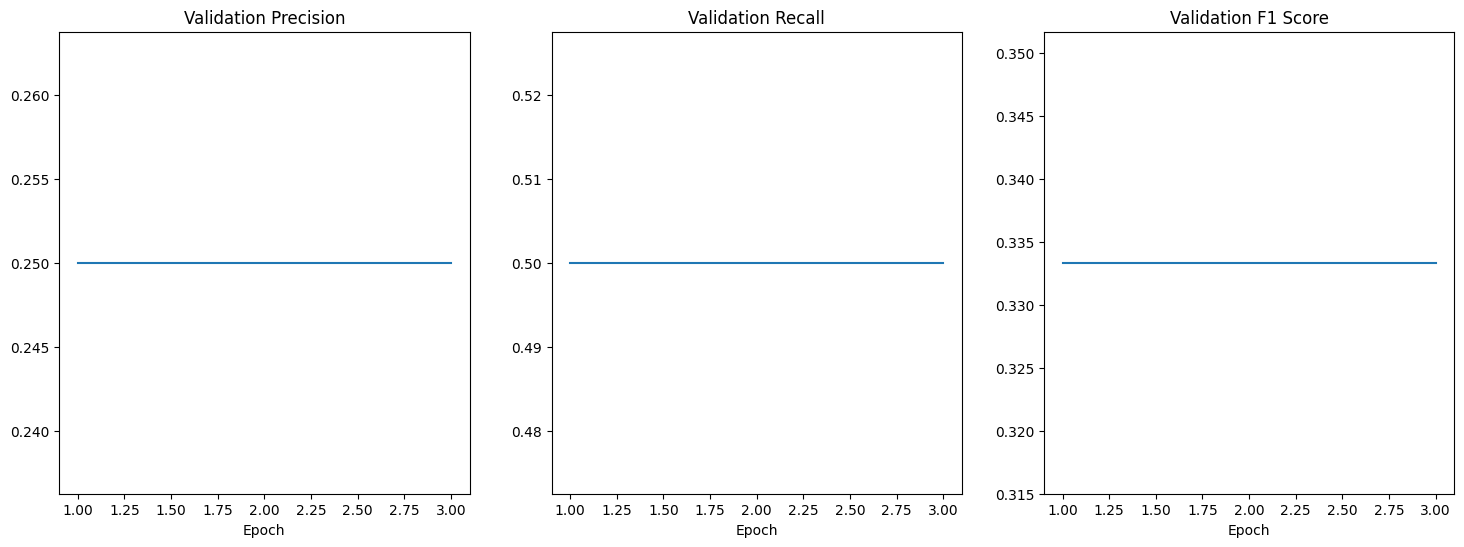

In [5]:
# 记录训练过程的数据
epoch_loss_values = []
metric_values = []
best_acc = 0.0
# 记录训练过程中的准确率、精确率、召回率和F1值
train_precision_values = []
train_recall_values = []
train_f1_values = []
val_precision_values = []
val_recall_values = []
val_f1_values = []


# 开始训练
for epoch in range(config.num_epochs):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    train_preds, train_labels = [], []
    val_preds, val_labels = [], []

    # 训练模型
    model.train()

    # 定义进度条
    for i,train_idx in enumerate(tqdm(train_data)):
        features, labels = train_idx
        features = features.cuda()
        labels = labels.cuda()
        optimizer.zero_grad() 
        outputs = model(features) 
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward() 
        optimizer.step() 
        # 计算训练集的准确率和损失
        _, train_pred = torch.max(outputs, 1) 
        train_acc += (train_pred.detach() == labels.detach()).sum().item()
        train_loss += loss.item()
        # 记录训练过程中的预测值和标签
        train_preds.extend(train_pred.detach().cpu().numpy().tolist())
        train_labels.extend(labels.detach().cpu().numpy().tolist())

    # 验证模型
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_data)):
            features, labels = batch
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features)
            loss = criterion(outputs, labels) 
            _, val_pred = torch.max(outputs, 1) 
            val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
            val_loss += loss.item()
            # 记录验证过程中的预测值和标签
            val_preds.extend(val_pred.cpu().numpy().tolist())
            val_labels.extend(labels.cpu().numpy().tolist())

    epoch_loss_values.append(train_loss/len(train_data))
    metric_values.append(val_acc/25000)

    # 计算训练过程中的准确率、精确率、召回率和F1值
    train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
    train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)
    train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)
    train_precision_values.append(train_precision)
    train_recall_values.append(train_recall)
    train_f1_values.append(train_f1)
    # 计算验证过程中的准确率、精确率、召回率和F1值
    val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    val_precision_values.append(val_precision)
    val_recall_values.append(val_recall)
    val_f1_values.append(val_f1)

    print(f'Model Status: [{epoch+1:03d}/{config.num_epochs:03d}] | '
      f'Train Acc: {train_acc/25000:3.5f} | '
      f'Loss: {train_loss/len(train_data):3.5f} | '
      f'Train Precision: {train_precision:3.5f} | '
      f'Train Recall: {train_recall:3.5f} | '
      f'Train F1 Score: {train_f1:3.5f} | '
      f'Val Acc: {val_acc/25000:3.5f} | '
      f'Loss: {val_loss/len(test_data):3.5f} | '
      f'Val Precision: {val_precision:3.5f} | '
      f'Val Recall: {val_recall:3.5f} | '
      f'Val F1 Score: {val_f1:3.5f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), config.checkpoint_path)
        print(f'saving model with acc {best_acc/25000:.5f}')
    

# 画出训练过程中的损失曲线以及准确率曲线
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [ (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.savefig('train.jpg')
plt.show()

# 画出训练过程中的精确率、召回率和F1分数曲线
plt.figure("train_metrics", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Train Precision")
x = [(i + 1) for i in range(len(train_precision_values))]
y = train_precision_values
plt.xlabel("Epoch")
plt.plot(x, y)

plt.subplot(1, 3, 2)
plt.title("Train Recall")
x = [(i + 1) for i in range(len(train_recall_values))]
y = train_recall_values
plt.xlabel("Epoch")
plt.plot(x, y)

plt.subplot(1, 3, 3)
plt.title("Train F1 Score")
x = [(i + 1) for i in range(len(train_f1_values))]
y = train_f1_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.savefig('train_metrics.jpg')
plt.show()

plt.figure("val_metrics", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Validation Precision")
x = [(i + 1) for i in range(len(val_precision_values))]
y = val_precision_values
plt.xlabel("Epoch")
plt.plot(x, y)

plt.subplot(1, 3, 2)
plt.title("Validation Recall")
x = [(i + 1) for i in range(len(val_recall_values))]
y = val_recall_values
plt.xlabel("Epoch")
plt.plot(x, y)

plt.subplot(1, 3, 3)
plt.title("Validation F1 Score")
x = [(i + 1) for i in range(len(val_f1_values))]
y = val_f1_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.savefig('val_metrics.jpg')
plt.show()

